In [2]:
import os
import sys
cwd = os.getcwd()
new_wd = '../src/visualization/'

os.chdir(new_wd)
from multistats import getstats
os.chdir(cwd)

In [3]:
import pandas as pd
from pandas_profiling import ProfileReport
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import math

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [4]:
df = pd.read_csv('../data/interim/prepared_consolidated_data.csv', sep='~', encoding='utf-8')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182776 entries, 0 to 182775
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   file_name                 182776 non-null  object 
 1   sheet_name                182776 non-null  object 
 2   trans_date                182776 non-null  object 
 3   original_gross_amt        182776 non-null  float64
 4   merchant_name             182776 non-null  object 
 5   card_number               182776 non-null  object 
 6   trans_cac_desc_1_imputed  182776 non-null  object 
 7   trans_cac_desc_2_imputed  182776 non-null  object 
 8   directorate_completed     182776 non-null  object 
dtypes: float64(1), object(8)
memory usage: 12.6+ MB


,file_name,sheet_name,trans_date,original_gross_amt,merchant_name,card_number,trans_cac_desc_1_imputed,trans_cac_desc_2_imputed,directorate_completed
0,cusersfinainmndesktoppublish-copy-january-2017...,Sheet1,2017-01-03,72.61,shell kings 587,************5770,Vehicle Fuel,African-Caribbean DC,Adult & Communities
1,cusersfinainmndesktoppublish-copy-january-2017...,Sheet1,2017-01-24,85.51,shell fiveways 387,************1147,Vehicle Fuel,Elders Group - Ladywood,Adult & Communities
2,cusersfinainmndesktoppublish-copy-january-2017...,Sheet1,2017-02-01,10.09,shell fiveways 387,************1147,Vehicle Fuel,Elders Group - Ladywood,Adult & Communities
3,cusersfinainmndesktoppublish-copy-january-2017...,Sheet1,2017-01-04,20.00,mibsons service st,************5804,Vehicle Fuel,Enablement Tyburn Rd,Adult & Communities
4,cusersfinainmndesktoppublish-copy-january-2017...,Sheet1,2017-01-05,50.00,malthurst petroleu,************5804,Vehicle Fuel,Enablement Tyburn Rd,Adult & Communities


________________
### Pandas Profiling

In [5]:
profile = ProfileReport(df, title="Purchase Card Transactions", explorative=True)
profile.to_file('../reports/Data Profile - Purchase Card Transactions.html')

Summarize dataset:   0%|          | 0/22 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
profile

________________
### Historical data frame

In [7]:
df_hist = df.groupby(['trans_date'], as_index=False)['original_gross_amt'].agg(['count', 'sum']).rename(columns={'count':'n_transactions','sum':'gross_amt'})
df_hist.describe().T.style.format('{:,.0f}')

,count,mean,std,min,25%,50%,75%,max
n_transactions,"1,332",137,92,1,40,148,214,467
gross_amt,"1,332","23,756","38,402","-630,766","2,209","16,579","30,399","562,059"


In [8]:
df_hist.reset_index(inplace=True)
df_hist.info()
df_hist.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1332 entries, 0 to 1331
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   trans_date      1332 non-null   object 
 1   n_transactions  1332 non-null   int64  
 2   gross_amt       1332 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 31.3+ KB


,trans_date,n_transactions,gross_amt
0,2013-11-12,1,-594.00
1,2014-03-06,1,98.33
2,2014-03-27,1,-10.54
3,2014-04-01,1,94.93
4,2014-04-02,11,2150.25


In [9]:
df_hist['trans_date_year'] = pd.to_datetime(df_hist['trans_date']).dt.year
df_hist['trans_date_month'] = pd.to_datetime(df_hist['trans_date']).dt.month
df_hist['trans_date_day'] = pd.to_datetime(df_hist['trans_date']).dt.day
df_hist.head()

,trans_date,n_transactions,gross_amt,trans_date_year,trans_date_month,trans_date_day
0,2013-11-12,1,-594.00,2013,11,12
1,2014-03-06,1,98.33,2014,3,6
2,2014-03-27,1,-10.54,2014,3,27
3,2014-04-01,1,94.93,2014,4,1
4,2014-04-02,11,2150.25,2014,4,2


trans_date_year,2013,2014,2015,2016,2017,2018
count,12,12,12,12,12,12
mean,0,"2,833","3,681","4,312","3,949",457
std,0,"2,558","1,353",835,"1,523","1,367"
min,0,0,208,"2,553",10,0
25%,0,99,"3,532","3,905","3,599",0
50%,0,"3,082","4,037","4,501","4,374",0
75%,0,"4,120","4,520","4,969","4,925",0
max,1,"8,343","5,014","5,235","5,318","4,747"


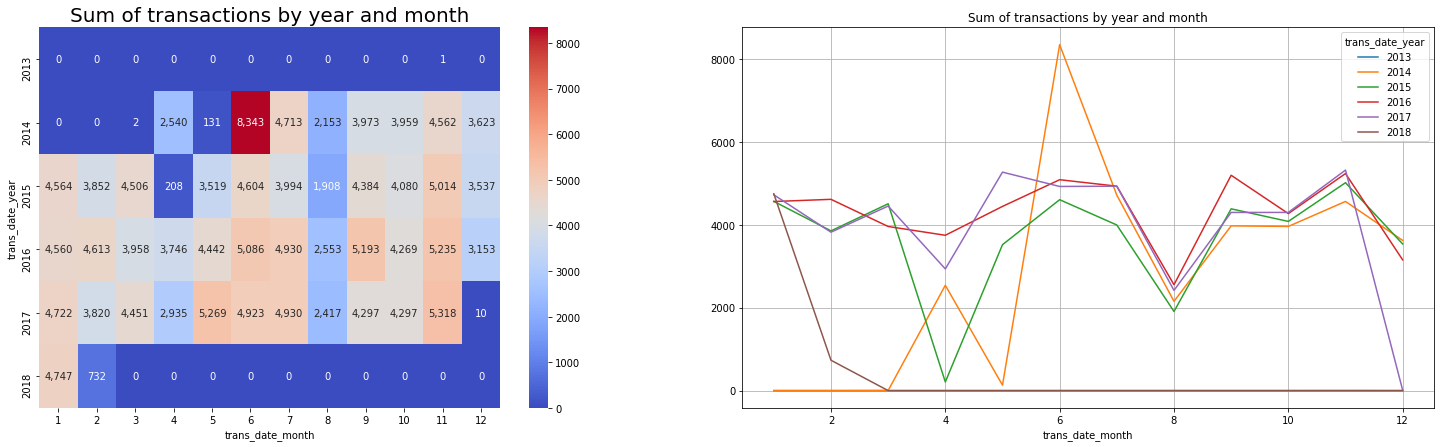

In [10]:
df_heatmap = df_hist.pivot_table(values='n_transactions', index='trans_date_year', columns='trans_date_month', aggfunc='sum', fill_value=0, dropna=False)

f, (heatmap, lineplot) = plt.subplots(1,2,figsize=(25,7), gridspec_kw={'width_ratios':(0.5,0.6)})
sns.heatmap(
    data = df_heatmap,
    annot=True,
    fmt=',.0f',
    cmap = 'coolwarm',
    ax = heatmap
)
heatmap.set_title('Sum of transactions by year and month', fontdict= {'fontsize':20})

df_heatmap.T.plot(kind='line', grid=True, title='Sum of transactions by year and month', ax=lineplot)

df_heatmap.T.describe().style.format('{:,.0f}')

**Analysis**:
1. In there are only one transation on 2013 (november).
2. In 2014 the transactions starts on April, there are 2 transactions on March of the same year, and a low number of transactions on May compared with the rest of the months.
3. On 2015 there are low number of transactions on April.
4. 2016 looks like are the most normal data, the average number of transactions by month is 4,312 with a standard deviation of 835 (lower than other years).
5. 2017 have good data until December.
6. 2018 have only data on January and a little on february.
7. It looks like on November of each year increment the number of transactions.
8. On August of each year we can see lower number of transactions compared with the other months.

### Building df_merchant

In [11]:
df_merchant = df.groupby(['merchant_name', 'trans_date'], as_index=False)['original_gross_amt'].agg(['count', 'sum']).rename(columns={'count':'n_transactions','sum':'gross_amt'}).reset_index()
df_merchant['trans_date_year'] = pd.to_datetime(df_merchant['trans_date']).dt.year
df_merchant['trans_date_month'] = pd.to_datetime(df_merchant['trans_date']).dt.month
df_merchant['trans_date_day'] = pd.to_datetime(df_merchant['trans_date']).dt.day

df_merchant = df_merchant.query('trans_date_year >= 2014 and trans_date_year <= 2017').pivot_table(
    values=['n_transactions', 'gross_amt'],
    index='merchant_name',
    columns='trans_date_year',
    aggfunc='sum',
    fill_value=0,
    dropna=False,
)
df_merchant.columns = [f'gross_amt_{x}' for x in range(2014,2018)] + [f'n_transactions_{x}' for x in range(2014,2018)]

df_merchant.head()

,gross_amt_2014,gross_amt_2015,gross_amt_2016,gross_amt_2017,n_transactions_2014,n_transactions_2015,n_transactions_2016,n_transactions_2017
merchant_name,,,,,,,,
.carelpress.co.uk,419.70,174.42,0.00,0.00,3,3,0,0
.ukgardensupplies.,0.00,832.93,158.95,115.96,0,2,1,1
01direct ltd,0.00,479.99,0.00,0.00,0,1,0,0
02 (uk) limited,0.00,0.00,0.00,303.22,0,0,0,1
02035190705 book,88.64,0.00,0.00,0.00,1,0,0,0


In [1]:
from pycaret.clustering import *

### original_gross_amt

In [ ]:
import math

In [ ]:
math.log10()

### Building a dataset with a merchant in each row to perform a clustering analysis